## **Rainfall**

In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from catboost import CatBoostClassifier
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

In [207]:
url_train='train.csv'
url_test='test.csv'
url_sample='sample_submission.csv'

train=pd.read_csv(url_train,sep=',')
test=pd.read_csv(url_test,sep=',')
sample=pd.read_csv(url_sample,sep=',')

In [208]:
print(train.shape)
print(test.shape)

(2190, 13)
(730, 12)


In [209]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [210]:
train.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [211]:
test.isnull().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [212]:
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)

In [213]:
train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [214]:
train['rainfall'].value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

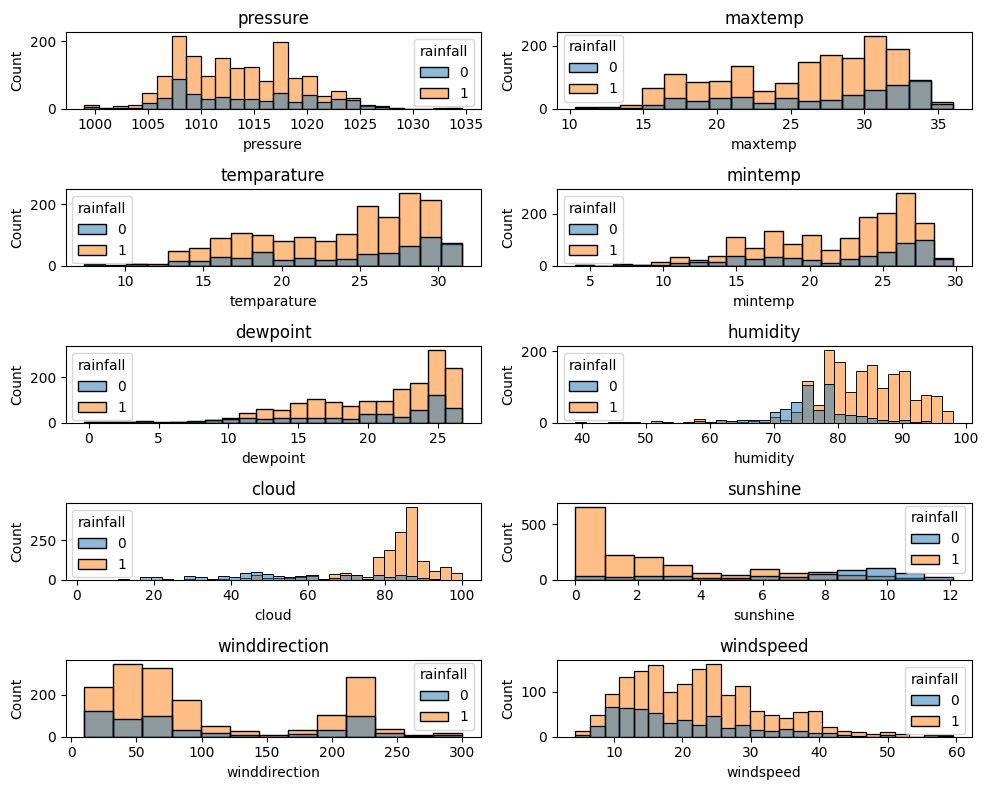

In [215]:
num=train.select_dtypes(include='number').columns
num=['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
fig,axs=plt.subplots(5,2,figsize=(10,8))
for i,col in enumerate(num):
       row=i//2
       col_idx=i%2
       sns.histplot(data=train,x=col,ax=axs[row,col_idx],hue='rainfall')
       axs[row,col_idx].set_title(col)
plt.tight_layout()
plt.show()

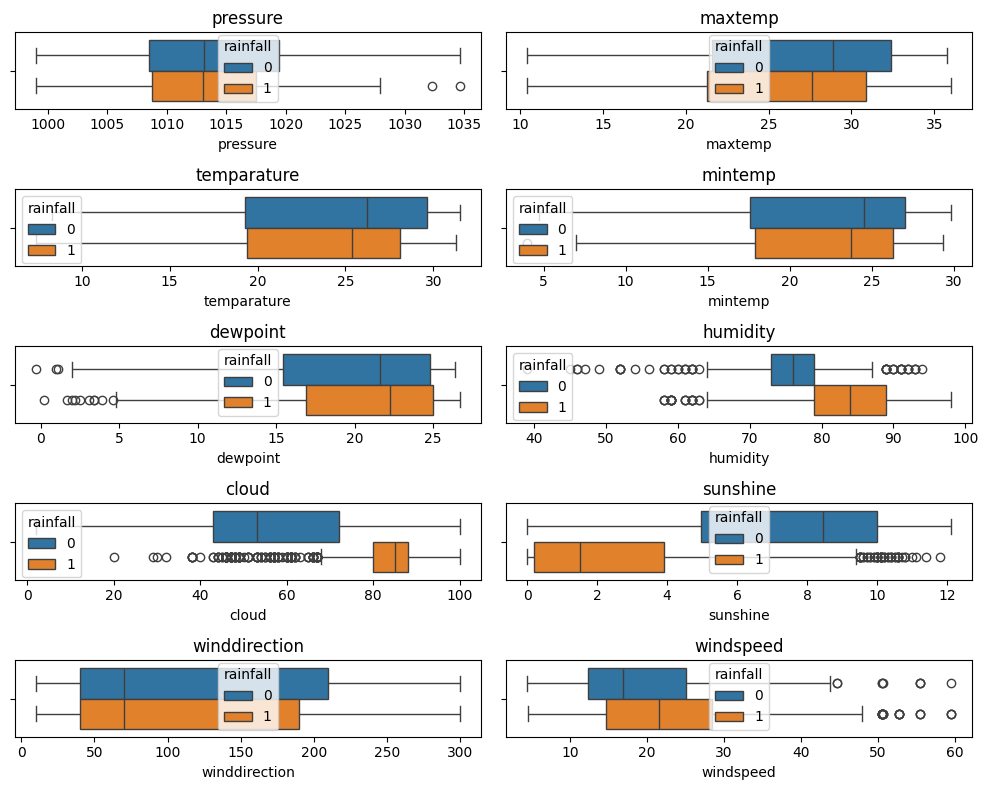

In [216]:
fig,axs=plt.subplots(5,2,figsize=(10,8))
for i,col in enumerate(num):
    row=i//2
    col_idx=i%2
    sns.boxplot(data=train,x=col,ax=axs[row,col_idx],hue='rainfall')
    axs[row,col_idx].set_title(col)
plt.tight_layout()
plt.show()

In [217]:
train[train['rainfall']==1][num].describe()
#train[num].describe()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000,1650.000000
mean,1013.440788,26.109333,23.804727,22.092424,20.702485,84.063030,82.332727,2.592727,104.545636,22.436667
std,5.383653,5.528607,5.061223,4.887762,4.951901,6.910826,11.113242,2.886441,78.449369,9.823536
min,999.000000,10.400000,7.400000,4.000000,0.200000,58.000000,20.000000,0.000000,10.000000,4.500000
25%,1008.725000,21.300000,19.400000,17.900000,16.900000,79.000000,80.000000,0.200000,40.000000,14.600000
50%,1013.000000,27.600000,25.400000,23.700000,22.250000,84.000000,85.000000,1.500000,70.000000,21.600000
75%,1017.500000,30.900000,28.100000,26.300000,25.000000,89.000000,88.000000,3.900000,190.000000,28.400000
max,1034.600000,36.000000,31.300000,29.300000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000


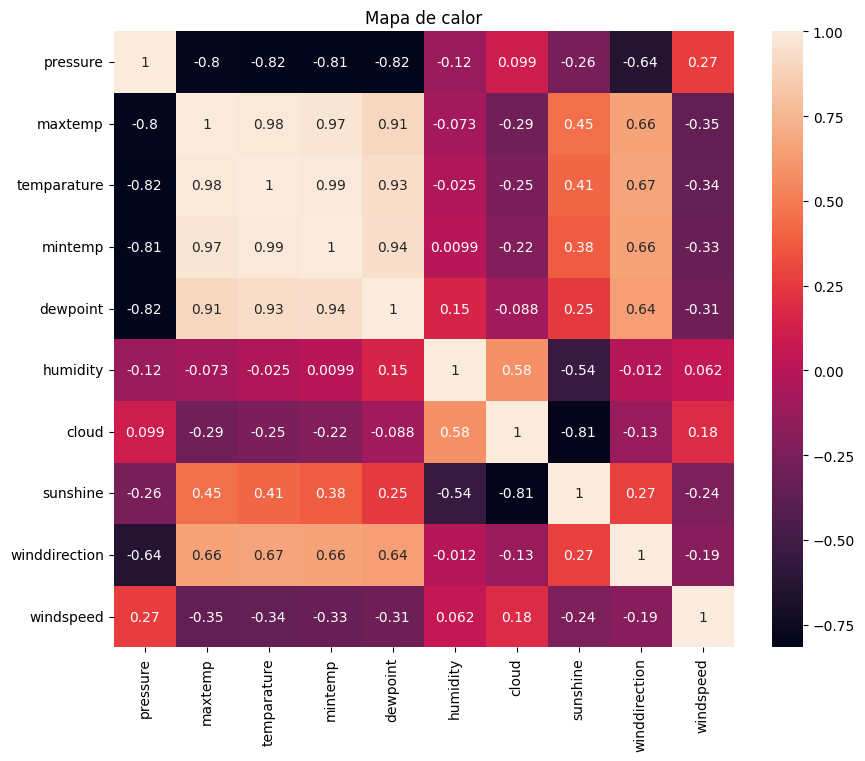

In [218]:
plt.figure(figsize=(10,8))
sns.heatmap(train[num].corr(),annot=True)
plt.title('Mapa de calor')
plt.show()

## **Date preprocessing**

In [219]:
# Impute the missing value with the median
test['winddirection'].fillna(test['winddirection'].median(), inplace=True)

In [220]:
train.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall'],
      dtype='object')

In [221]:
def data_preprocessing(df):
        # Temperature Difference - Difference between max and min temperature
    df['Temp_Diff'] = df['maxtemp'] - df['mintemp']

    # Dew Point Spread - Difference between temperature and dew point
    df['Dew_Point_Spread'] = df['temparature'] - df['dewpoint']

    # Humidity Category - Binning humidity into low, medium, and high
    df['Humidity_Category'] = pd.cut(df['humidity'], bins=[0, 50, 80, 100], labels=['Low', 'Medium', 'High'])

    # Cloud Cover Category - Grouping cloud cover into bins
    df['Cloud_Cover_Category'] = pd.cut(df['cloud'], bins=[0, 30, 70, 100], labels=['Clear', 'Partly Cloudy', 'Overcast'])

    # Sunshine Duration Category - Categorizing sunshine duration
    df['Sunshine_Category'] = pd.cut(df['sunshine'], bins=[0, 3, 7, 12], labels=['Low', 'Medium', 'High'])

    # Wind Speed Intensity - Categorizing wind speeds
    df['Wind_Speed_Intensity'] = pd.cut(df['windspeed'], bins=[0, 10, 25, 60], labels=['Calm', 'Breezy', 'Windy'])

    # Wind Direction Grouping - Binning wind direction into 4 quadrants
    df['Wind_Quadrant'] = pd.cut(df['winddirection'], bins=[0, 90, 180, 270, 360], labels=['NE', 'SE', 'SW', 'NW'], include_lowest=True)

    # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
    df['Pressure_Humidity_Interaction'] = df['pressure'] * df['humidity']

    # Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
    df['Wind_Cloud_Interaction'] = df['windspeed'] * df['cloud']

    # Temperature Ratio - Normalized temperature based on max recorded value
    df['Temp_Ratio'] = df['temparature'] / df['maxtemp'].max()

    return df
train=data_preprocessing(train)
test=data_preprocessing(test)    

In [222]:
train = train.dropna(subset=['Sunshine_Category'])
test = test.dropna(subset=['Sunshine_Category'])

In [223]:
print(train['Sunshine_Category'].value_counts())

Sunshine_Category
Low       873
High      520
Medium    459
Name: count, dtype: int64


In [224]:
columns_to_check= ['dewpoint', 'humidity', 'cloud', 'windspeed']

def remove_outliers_iqr_with_plot(data, column):
    Q1 = data[column].quantile(0.15)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    # Calculate the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)
    
    # Plot the distribution with outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column], color='lightblue', flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
    
    # Highlight Q1 and Q3
    plt.axvline(Q1, color='green', linestyle='--', label='Q1 (10th Percentile)')
    plt.axvline(Q3, color='blue', linestyle='--', label='Q3 (90th Percentile)')
    
    # Highlight lower and upper bounds
    plt.axvline(lower_bound, color='red', linestyle='-', label='Lower Bound')
    plt.axvline(upper_bound, color='red', linestyle='-', label='Upper Bound')

    plt.title(f'Outlier Detection for {column}')
    plt.legend()
    plt.xlabel(column)
    plt.show()
    
    return filtered_data, rows_deleted

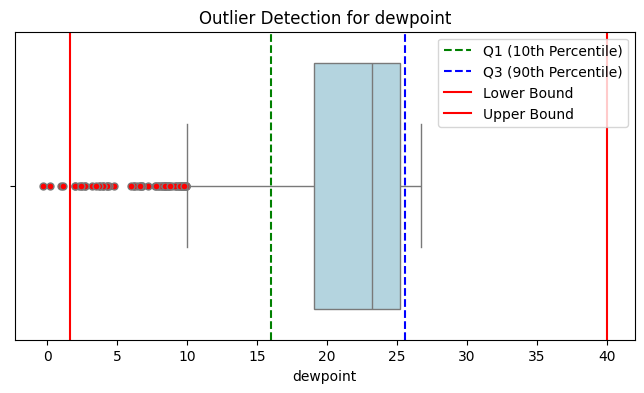

Rows deleted for dewpoint: 4


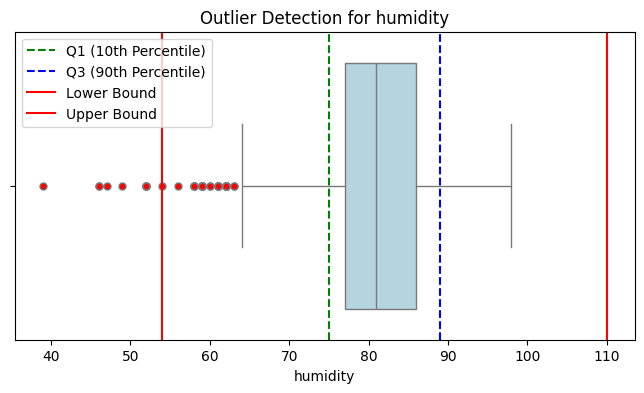

Rows deleted for humidity: 9


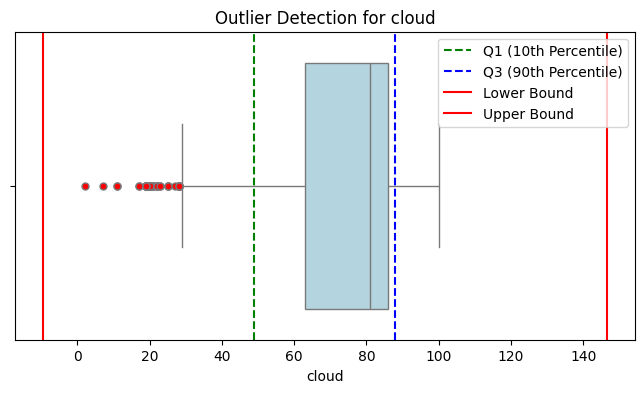

Rows deleted for cloud: 0


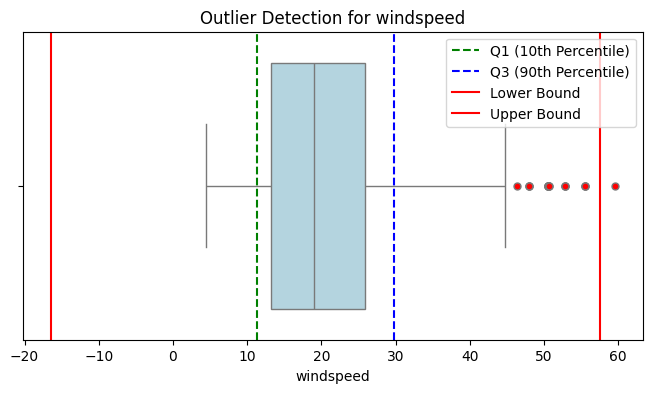

Rows deleted for windspeed: 1
Total rows deleted: 14


In [225]:
# Apply function to each numerical column and visualize
rows_deleted_total = 0

for column in columns_to_check:
    train, rows_deleted = remove_outliers_iqr_with_plot(train, column)
    rows_deleted_total += rows_deleted
    print(f"Rows deleted for {column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

In [226]:
train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,Temp_Diff,Dew_Point_Spread,Humidity_Category,Cloud_Cover_Category,Sunshine_Category,Wind_Speed_Intensity,Wind_Quadrant,Pressure_Humidity_Interaction,Wind_Cloud_Interaction,Temp_Ratio
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,1.3,1.2,High,Overcast,Low,Breezy,NE,88513.8,1513.6,0.572222
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,4.8,6.8,Medium,Partly Cloudy,High,Breezy,NE,76807.5,850.7,0.447222
6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,...,4.2,7.1,Medium,Partly Cloudy,High,Windy,NE,57276.8,1306.4,0.511111
9,10,1025.4,16.5,14.4,12.0,8.6,77.0,84.0,1.0,50.0,...,4.5,5.8,Medium,Overcast,Low,Windy,NE,78955.8,3217.2,0.400000
14,15,1018.4,17.8,16.5,15.1,12.1,77.0,85.0,1.2,40.0,...,2.7,4.4,Medium,Overcast,Low,Breezy,NE,78416.8,1776.5,0.458333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,359,1016.9,18.4,16.4,15.3,13.6,79.0,84.0,2.4,40.0,...,3.1,2.8,Medium,Overcast,Low,Windy,NE,80335.1,3192.0,0.455556
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,...,4.1,0.7,High,Overcast,Low,Breezy,NE,98416.2,1944.8,0.572222
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,...,4.7,3.7,Medium,Overcast,Medium,Windy,NE,80050.7,2599.1,0.452778
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,...,2.6,0.5,High,Overcast,Low,Breezy,NE,94051.6,1674.0,0.422222


In [227]:
y=train['rainfall']

In [228]:
numerical_variables = ['winddirection', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']

Features to be transformed (skewness > 0.75):


array(['windspeed'], dtype=object)

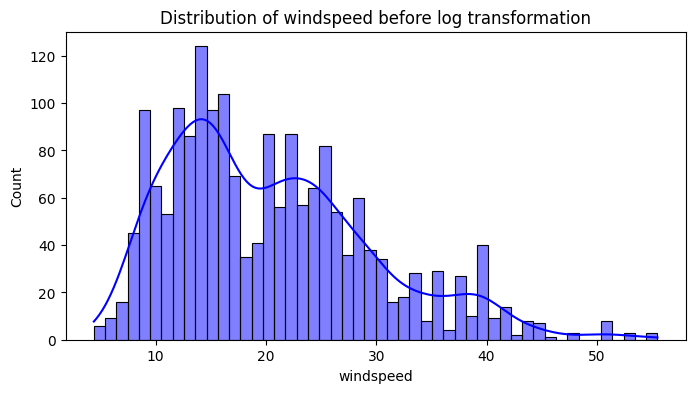

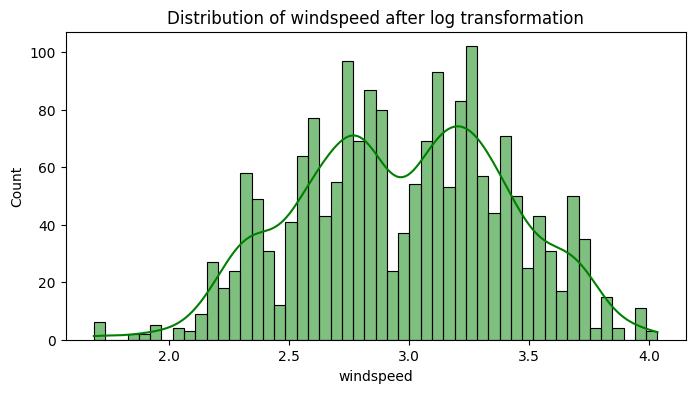

In [229]:
skewed_features = train[numerical_variables].skew()[train[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p transformation to skewed features
train[skewed_features] = np.log1p(train[skewed_features])

# Plot skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[feature], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {feature} after log transformation')
    plt.show()

In [230]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1838 entries, 0 to 2189
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   day                            1838 non-null   int64   
 1   pressure                       1838 non-null   float64 
 2   maxtemp                        1838 non-null   float64 
 3   temparature                    1838 non-null   float64 
 4   mintemp                        1838 non-null   float64 
 5   dewpoint                       1838 non-null   float64 
 6   humidity                       1838 non-null   float64 
 7   cloud                          1838 non-null   float64 
 8   sunshine                       1838 non-null   float64 
 9   winddirection                  1838 non-null   float64 
 10  windspeed                      1838 non-null   float64 
 11  rainfall                       1838 non-null   int64   
 12  Temp_Diff                      1838 non

In [231]:
cat=train.select_dtypes(include='category').columns
for i in cat:
    le=LabelEncoder()
    train[i]=le.fit_transform(train[i])

In [232]:
cat

Index(['Humidity_Category', 'Cloud_Cover_Category', 'Sunshine_Category',
       'Wind_Speed_Intensity', 'Wind_Quadrant'],
      dtype='object')

In [233]:
train.drop(columns=['humidity', 'cloud', 'sunshine', 'windspeed', 'winddirection'], inplace=True)

In [234]:
# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(train.drop(['rainfall'], axis=1))

# Scale the training data
scaled_data_train = minmax_scaler.transform(train.drop(['rainfall'], axis=1))
scaled_train_df = pd.DataFrame(scaled_data_train, columns=train.drop(['rainfall'], axis=1).columns)

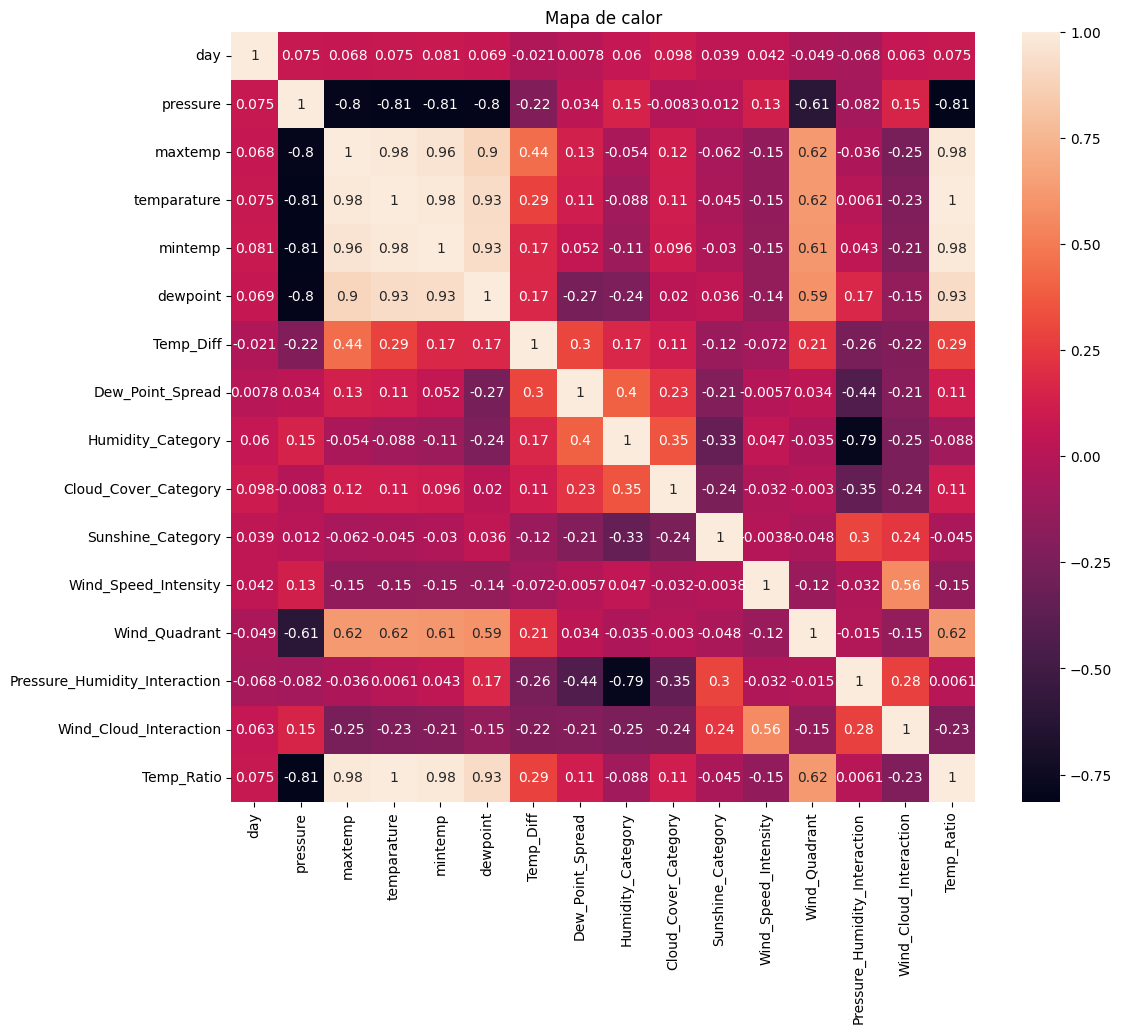

In [235]:
plt.figure(figsize=(12,10))
sns.heatmap(scaled_train_df.corr(),annot=True)
plt.title('Mapa de calor')
plt.show()

## **Modelo de Machine Learning**

In [237]:
# Divide los datos en entrenamiento y prueba
X=scaled_train_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Crea un modelo de regresión logística
modelo = LogisticRegression()

# Entrena el modelo
modelo.fit(X_train, y_train)

# Realiza predicciones
y_pred = modelo.predict(X_test)

# Evalúa el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_report(y_test, y_pred))

(1470, 16)
(368, 16)
(1470,)
(368,)
Precisión: 0.8179347826086957
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.62      0.67       108
           1       0.85      0.90      0.87       260

    accuracy                           0.82       368
   macro avg       0.79      0.76      0.77       368
weighted avg       0.81      0.82      0.81       368



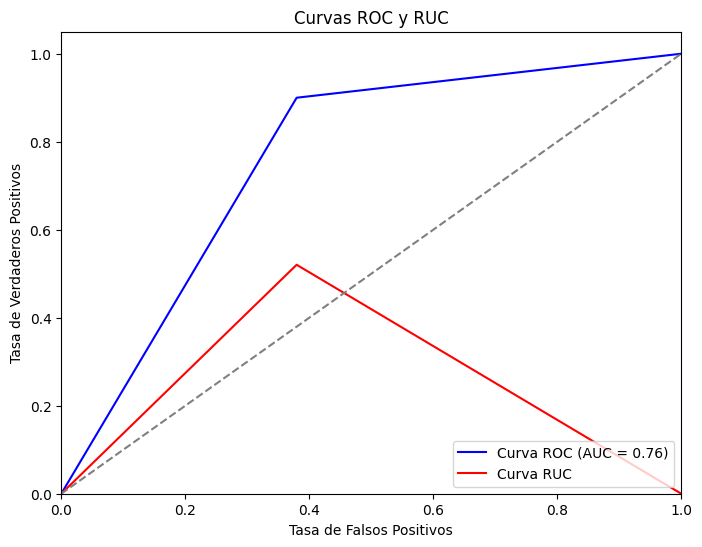

In [238]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcula el área bajo la curva ROC
auc_roc = auc(fpr, tpr)

# Calcula la curva RUC
ruc = tpr - fpr

# Crea el gráfico
plt.figure(figsize=(8, 6))

# Curva ROC
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % auc_roc)

# Curva RUC
plt.plot(fpr, ruc, color='red', label='Curva RUC')

# Línea de referencia para la curva ROC
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Configura el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC y RUC')
plt.legend(loc="lower right")
plt.show()

In [239]:
# Divide los datos en entrenamiento y prueba
X=scaled_train_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define los hiperparámetros del modelo
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1
}

# Crea un modelo XGBoost con los hiperparámetros especificados
modelo = xgb.XGBClassifier(**params)

# Entrena el modelo
modelo.fit(X_train, y_train)

# Realiza predicciones
y_pred = modelo.predict(X_test)

# Evalúa el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_report(y_test, y_pred))

(1470, 16)
(368, 16)
(1470,)
(368,)
Precisión: 0.8260869565217391
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       103
           1       0.86      0.91      0.88       265

    accuracy                           0.83       368
   macro avg       0.79      0.76      0.77       368
weighted avg       0.82      0.83      0.82       368



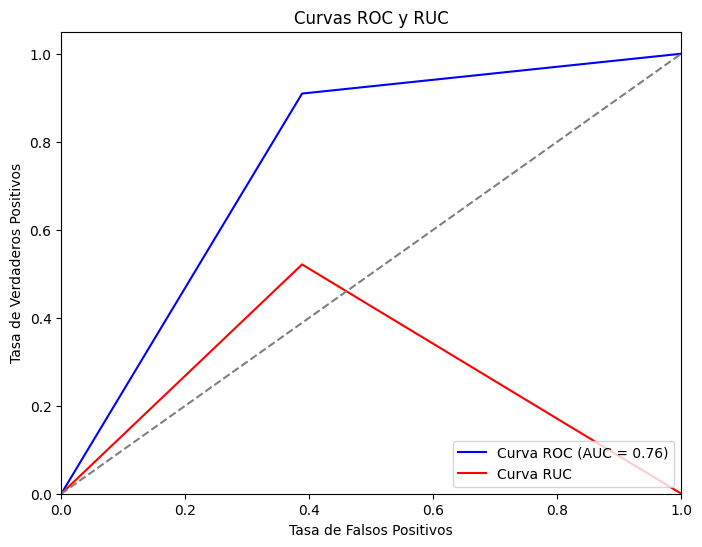

In [240]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcula el área bajo la curva ROC
auc_roc = auc(fpr, tpr)

# Calcula la curva RUC
ruc = tpr - fpr

# Crea el gráfico
plt.figure(figsize=(8, 6))

# Curva ROC
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % auc_roc)

# Curva RUC
plt.plot(fpr, ruc, color='red', label='Curva RUC')

# Línea de referencia para la curva ROC
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Configura el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC y RUC')
plt.legend(loc="lower right")
plt.show()

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define los hiperparámetros del modelo
params = {
    'iterations': 1286, 
    'depth': 4, 
    'learning_rate': 0.010125264703510092,
    'l2_leaf_reg': 7.451015186407337, 
    'subsample': 0.6051703546923786, 
    'random_strength': 7.73762440525015e-06, 
    'bagging_temperature': 6.019141367507094, 
    'border_count': 33
}

# Crea un modelo XGBoost con los hiperparámetros especificados
modelo = CatBoostClassifier(**params,custom_loss=['AUC', 'Accuracy'])

# Entrena el modelo
modelo.fit(X_train, y_train)

# Realiza predicciones
y_pred = modelo.predict(X_test)

0:	learn: 0.6858596	total: 6.1ms	remaining: 7.83s
1:	learn: 0.6786165	total: 11.5ms	remaining: 7.36s
2:	learn: 0.6714223	total: 15.9ms	remaining: 6.81s
3:	learn: 0.6644735	total: 21ms	remaining: 6.71s
4:	learn: 0.6576970	total: 25.7ms	remaining: 6.58s
5:	learn: 0.6510887	total: 29.8ms	remaining: 6.36s
6:	learn: 0.6448541	total: 34.4ms	remaining: 6.28s
7:	learn: 0.6385648	total: 39.8ms	remaining: 6.36s
8:	learn: 0.6326869	total: 43.8ms	remaining: 6.22s
9:	learn: 0.6268411	total: 48.2ms	remaining: 6.15s
10:	learn: 0.6209969	total: 53.1ms	remaining: 6.16s
11:	learn: 0.6152991	total: 57ms	remaining: 6.05s
12:	learn: 0.6098422	total: 60.3ms	remaining: 5.9s
13:	learn: 0.6045137	total: 63.4ms	remaining: 5.76s
14:	learn: 0.5992110	total: 66.2ms	remaining: 5.61s
15:	learn: 0.5941282	total: 70.7ms	remaining: 5.61s
16:	learn: 0.5891422	total: 73.6ms	remaining: 5.5s
17:	learn: 0.5842198	total: 76.3ms	remaining: 5.38s
18:	learn: 0.5795677	total: 79.2ms	remaining: 5.28s
19:	learn: 0.5748660	total: 8

In [250]:
# Evalúa el modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)
print("Informe de clasificación:\n", classification_report(y_test, y_pred))

Precisión: 0.8478260869565217
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71       103
           1       0.88      0.92      0.90       265

    accuracy                           0.85       368
   macro avg       0.82      0.79      0.80       368
weighted avg       0.84      0.85      0.84       368



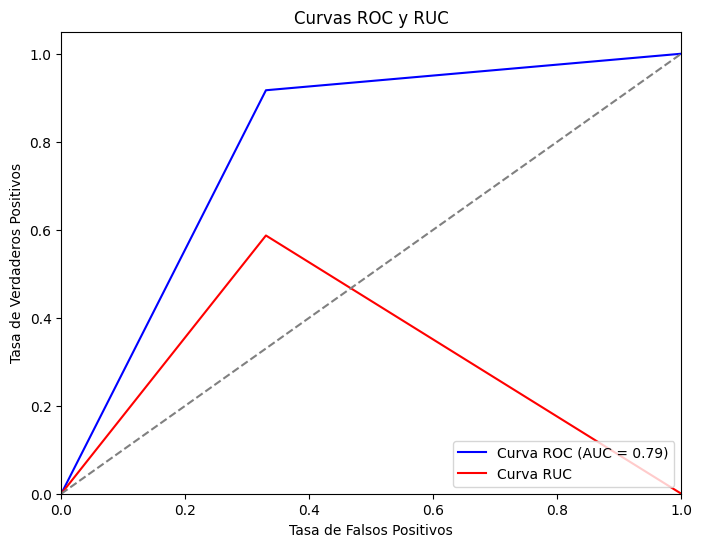

In [251]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcula el área bajo la curva ROC
auc_roc = auc(fpr, tpr)

# Calcula la curva RUC
ruc = tpr - fpr

# Crea el gráfico
plt.figure(figsize=(8, 6))

# Curva ROC
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % auc_roc)

# Curva RUC
plt.plot(fpr, ruc, color='red', label='Curva RUC')

# Línea de referencia para la curva ROC
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Configura el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC y RUC')
plt.legend(loc="lower right")
plt.show()